In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE=(224,224)

In [3]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/med_img/cervical-cancer2")
data_dir

PosixPath('/home/sanjana/Desktop/med_img/cervical-cancer2')

In [4]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

2052

In [5]:
lesions_dict_bin={
    'NILM': list(data_dir.glob('NILM/*')),
    'Abnormal': list(data_dir.glob('ABNORMAL/*')),
}

In [6]:
len(lesions_dict_bin['Abnormal'])

350

In [7]:
lesions_labels_bin={
    'NILM': 0,
    'Abnormal': 1,
}

In [8]:
xb, yb=[],[]
for lesions_name, images in lesions_dict_bin.items():
    for image in images:
        img=cv2.imread(str(image))
        xb.append(img)
        yb.append(lesions_labels_bin[lesions_name])

In [9]:
xb=np.array(xb)
yb=np.array(yb)

In [10]:
from sklearn.model_selection import train_test_split
x_trainb, x_testb, y_trainb, y_testb = train_test_split(xb, yb, test_size=0.2, random_state=1, shuffle=True)

x_trainb, x_valb, y_trainb, y_valb = train_test_split(x_trainb, y_trainb, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
x_train_scaledb=x_trainb/255
x_test_scaledb=x_testb/255
x_val_scaledb=x_valb/255
print(len(x_train_scaledb))
print(len(x_val_scaledb))
print(len(x_test_scaledb))

576
193
193


In [12]:
classifier="https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)

In [13]:
from sklearn.model_selection import KFold

In [14]:
num_lesions_bin=2
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

In [15]:

import matplotlib.pyplot as plt
acc_per_fold_bin=[]
loss_per_fold_bin=[]
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train_scaledb, y_trainb):
    model=tf.keras.Sequential([
        mod, 
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(num_lesions_bin)
    ])

    model.compile(
        optimizer="adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(x_train_scaledb, y_trainb, batch_size=20,epochs=10,callbacks = es)
    scores = model.evaluate(x_val_scaledb, y_valb, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold_bin.append(scores[1] * 100)
    loss_per_fold_bin.append(scores[0])
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
29/29 [==============================] - 11s 293ms/step - loss: 0.2080 - acc: 0.9184
Epoch 2/10
29/29 [==============================] - 8s 288ms/step - loss: 0.0339 - acc: 0.9896
Epoch 3/10
29/29 [==============================] - 8s 290ms/step - loss: 0.0027 - acc: 1.0000
Epoch 4/10
29/29 [==============================] - 8s 291ms/step - loss: 4.7792e-04 - acc: 1.0000
Epoch 5/10
29/29 [==============================] - 9s 292ms/step - loss: 2.1764e-04 - acc: 1.0000
Epoch 6/10
29/29 [==============================] - 8s 291ms/step - loss: 1.2912e-04 - acc: 1.0000
Epoch 7/10
29/29 [==============================] - 8s 289ms/step - loss: 9.3814e-05 - acc: 1.0000
Epoch 8/10
29/29 [==============================] - 9s 293ms/step - loss: 6.9623e-05 - acc: 1.0000
Epoch 9/10
29/29 [==============================] - 8s 290ms/step - loss: 5.3516e-05 - acc: 1.0000
Epoch 10/10
29/29 [====

KeyError: 'val_acc'

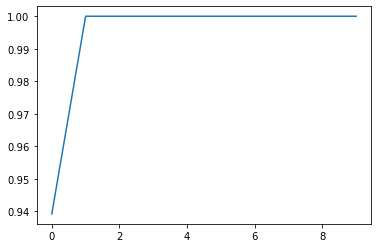

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model.evaluate(x_test_scaledb, y_testb)

7/7 [==============================] - 3s 388ms/step - loss: 0.0052 - acc: 0.9948


[0.0052468194626271725, 0.9948186278343201]

In [19]:
preds_b=model.predict(x_test_scaledb)
pred_classesb=np.argmax(preds_b, axis=1)
pred_classesb

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1])

In [20]:
class_labels=[0,1]
import sklearn.metrics as metrics
report = metrics.classification_report(y_testb, pred_classesb, class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_classes)

/home/sanjana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       127
           1       0.90      1.00      0.95        47
           2       0.94      0.85      0.89        39
           3       1.00      0.95      0.97        58

    accuracy                           0.96       271
   macro avg       0.96      0.95      0.95       271
weighted avg       0.96      0.96      0.96       271



array([[126,   1,   0,   0],
       [  0,  47,   0,   0],
       [  2,   4,  33,   0],
       [  1,   0,   2,  55]])